Folders are ready:
- Data folder: /home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/data/
- Processing folder: /home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/processing/
All required data files are present.


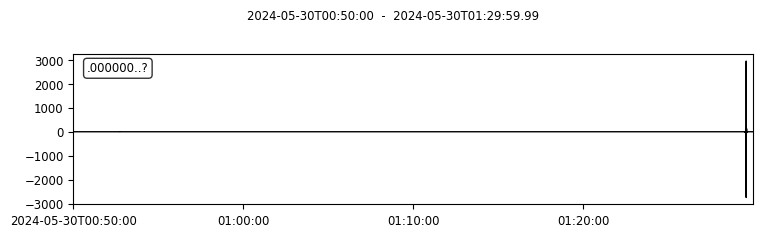

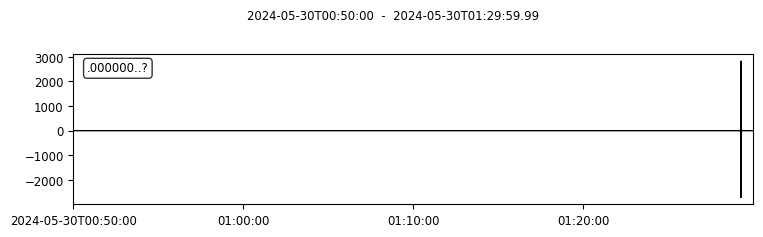

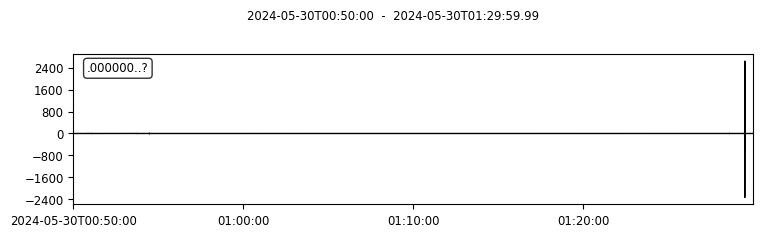

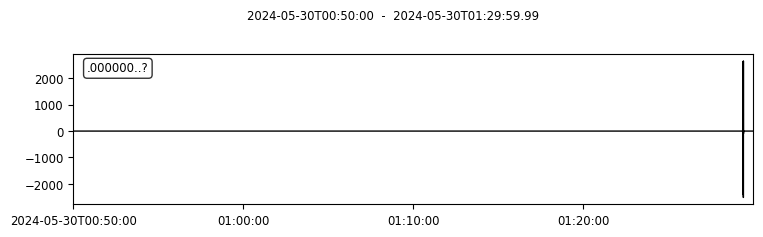

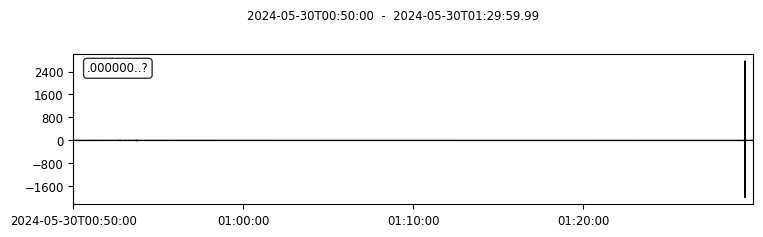

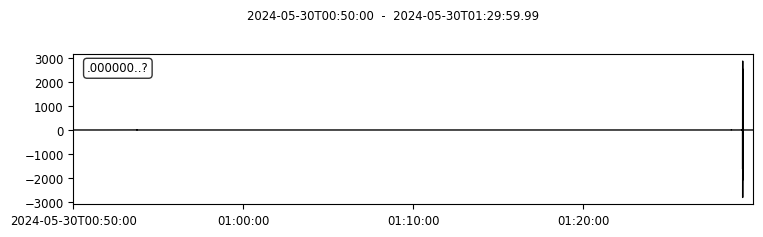

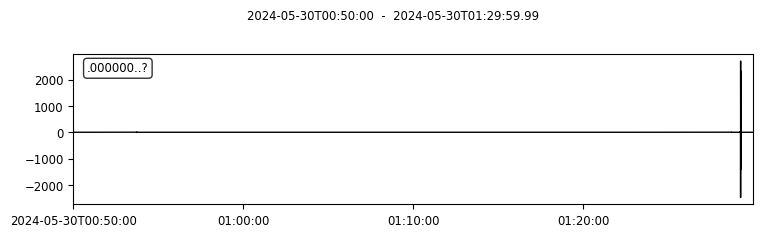

Processing receiver: g2.sac
panjang window = 2.7306666666666666 menit


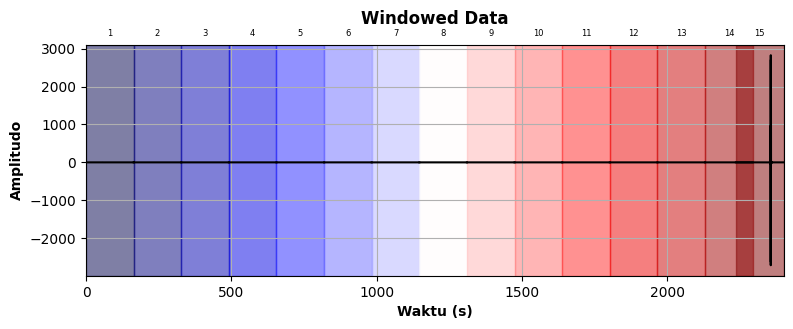

/home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/processing/g7.sac_window_14.txt /home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/processing/g3.sac_window_14.txt 14


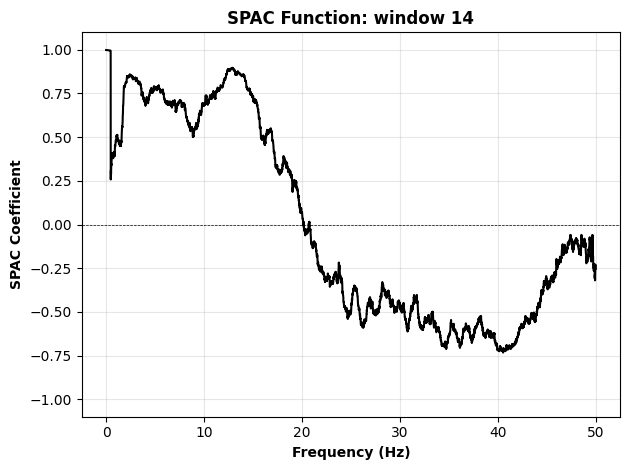

Pair g7.sac-g2.sac has windows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Pair g7.sac-g3.sac has windows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Pair g7.sac-g1.sac has windows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


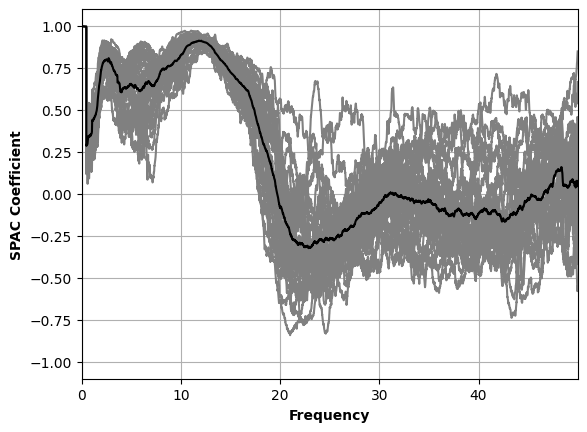

Number of samples reduced from 8192 to 164


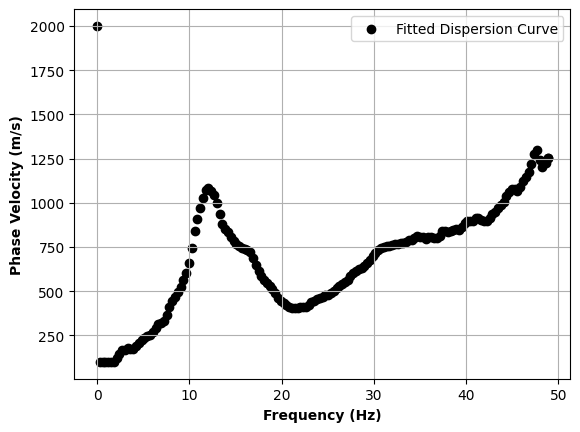

In [1]:
#REQUIRED MODULES
# import os
# import obspy
# import numpy as np
# from obspy import read
# import pandas
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from matplotlib.cm import get_cmap
# from scipy import signal
# from scipy.fftpack import fft, fftfreq
# from matplotlib.ticker import LogLocator, FixedLocator, MultipleLocator, LogFormatter
# from scipy.fft import fft, fftfreq
# from scipy.signal import decimate
# from scipy.special import jv
# from scipy.optimize import  least_squares
# import scipy

import os
import obspy
import numpy as np
from obspy import read
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from scipy import signal
from scipy.fft import fft, fftfreq  # Removed duplicate fft/fftfreq import
from matplotlib.ticker import LogLocator, FixedLocator, MultipleLocator, LogFormatter
from scipy.signal import decimate
from scipy.special import jv
from scipy.optimize import least_squares
import scipy

#SCRIPT
class SPACProcessing():
    def __init__(self, path):
        self.path = path
        self.path_data= f'{os.path.join(self.path, 'data')}/'
        self.path_processing= f'{os.path.join(self.path, 'processing')}/'
        self.make_folder()
        
    def make_folder(self):
        for folder in [self.path_data, self.path_processing]:
            os.makedirs(folder, exist_ok=True)
        print(f"Folders are ready:\n- Data folder: {self.path_data}\n- Processing folder: {self.path_processing}")


    class ReadData:
        def __init__(self, parent_path_data, data_fnames, data_format):
            self.path_data= parent_path_data.path_data
            # self.path_processing= parent_path.path_processing
            self.data_format= data_format
            self.data_fnames= data_fnames
            self.readed_data=[]
    
        def read_data(self):
            missing_files = [
                fname for fname in self.data_fnames 
                if not os.path.isfile(os.path.join(self.path_data, fname))
            ]
            if missing_files:
                print(f"Missing data files: {', '.join(missing_files)}")
                print(f"Please ensure all required files are placed in the data folder: {self.path_data}")
            else:
                print("All required data files are present.")
                
            data = []
            for i in [f'{self.path_data}{j}' for j in self.data_fnames]:
                a = read(i, format=self.data_format)
                stats = a[0].stats   
                receiver_name=i.split('/')[-1]
                datas = pandas.DataFrame({
                        'Path': [i],
                        'Network': [stats.network],
                        'Station': [stats.station],
                        'Location': [stats.location],
                        'Channel': [receiver_name],
                        'Starttime': [stats.starttime],
                        'Endtime': [stats.endtime],
                        'Sampling_rate': [stats.sampling_rate],
                        'Delta': [stats.delta],
                        'Npts': [stats.npts],
                        'Amplitude': [a[0].data[:]],
                        'Time': [a[0].times()[:]]
                })
                data.append(datas)
                self.readed_data.append(data)
                a.plot()        
            return data


    class Windowing:
        def __init__(self, parent_path_processing, parent_read_data, window_size):
            self.fname = parent_read_data.data_fnames
            self.readed_data= parent_read_data.readed_data
            self.time = []
            self.amplitude = []
            self.window_size = window_size
            self.path_processing = parent_path_processing.path_processing
            self.x = []  
            self.y = []
            self.n_window = 0
            
        def windowing(self, selected_receiver=None):
            data = self.readed_data[0]
            if selected_receiver is None:
                print(f"No receiver specified. Available receivers: {[i['Channel'][0] for i in data]}")
                return None
            receiver_data = None
            for i in data:
                if i['Channel'][0] == selected_receiver:  
                    receiver_data = i
                    break            
            if receiver_data is None:
                print(f"Receiver {selected_receiver} not found in the data.")
                return None            
            print(f"Processing receiver: {selected_receiver}")            
            n_sample = receiver_data['Npts'][0]
            n_window = n_sample / self.window_size
            self.time.append(receiver_data['Time'][0])
            self.amplitude.append(receiver_data['Amplitude'][0])                                         
            if n_window.is_integer():
                n_window = int(n_window)
                for n in range(n_window):
                    start_index = n * self.window_size
                    end_index = (n + 1) * self.window_size
                    self.x.append(receiver_data['Time'][0][start_index:end_index])
                    self.y.append(receiver_data['Amplitude'][0][start_index:end_index])
            else:
                n_window = int(np.floor(n_window)) + 1
                for n in range(n_window - 1):
                    start_index = n * self.window_size
                    end_index = (n + 1) * self.window_size
                    self.x.append(receiver_data['Time'][0][start_index:end_index])
                    self.y.append(receiver_data['Amplitude'][0][start_index:end_index])
                if len(self.x) < n_window:
                    n_shift = end_index - ((n_window * self.window_size) - n_sample)
                    self.x.append(receiver_data['Time'][0][int(n_shift):])
                    self.y.append(receiver_data['Amplitude'][0][int(n_shift):])            
            self.n_window = n_window
            for i in range(self.n_window):
                np.savetxt(f'{self.path_processing}/{selected_receiver}_window_{i + 1}.txt', 
                           np.column_stack((self.x[i], self.y[i])), 
                           header='#Sample (s) #Amplitude')
            # print(f'window length is{len(self.x[0])*data['Npts'][0]/60}')
            print(f'panjang window = {len(self.x[0])*data[0]['Delta'][0]/60} menit')            
            return self.n_window, self.x, self.y    
    
        def plot_windows(self):
            """Plot the windowed data."""
            plt.figure(figsize=(9, 3))
            cmap = plt.get_cmap('seismic')
            norm = mcolors.Normalize(vmin=1, vmax=self.n_window)    
            for i in range(self.n_window):
                plt.plot(self.x[i], self.y[i], c='black')
                plt.axvspan(self.x[i][0], self.x[i][-1], color=cmap(norm(i + 1)), alpha=0.5)
                plt.text(np.median(self.x[i]), max(np.concatenate(self.y)) + (max(np.concatenate(self.y)) * 0.2), 
                         s=(i + 1), ha='center', va='center', size=6)
    
            plt.xlabel('Waktu (s)', weight='bold')
            plt.ylabel('Amplitudo', weight='bold')
            plt.xlim(0, np.max(self.time))
            plt.title('Windowed Data', weight='bold', pad=15)
            plt.grid(True)
            plt.show()
    
    class ComplexCoherence:
        def __init__(self, parent_path_processing, n_window, fs, smooth_constant):
            self.path_processing = parent_path_processing.path_processing
            # self.window_no = window_no
            self.n_window = n_window.n_window
            self.fs = fs
            self.smooth_constant = smooth_constant
            self.f = []
            self.rho = []
            self.coherencies = []
            self.output_path= []
            
        def calculate_coherence(self, fname_1, fname_2, window_no):
            self.window_no = window_no
            file1 = os.path.join(self.path_processing, f"{fname_1}_window_{window_no}.txt")
            file2 = os.path.join(self.path_processing, f"{fname_2}_window_{window_no}.txt")
            print(file1, file2, window_no)                
            try:
                data1 = np.loadtxt(file1)
                data2 = np.loadtxt(file2)
                f = data1[:, 1]
                g = data2[:, 1]                
                if len(f) != len(g):
                    raise ValueError(f"Data lengths are different for window {i + 1}")                
                dt = 1/self.fs
                N = len(f)
                window = signal.windows.hann(N)
                
                f_w = f * window
                g_w = g * window
                f_fft = fft(f_w) * dt
                g_fft = fft(g_w) * dt
                f_fftfreq = fftfreq(N, 1/self.fs)[:N // 2]                
                cc_fg = f_fft * np.conj(g_fft)
                cc_fg_smooth = signal.convolve(cc_fg, 
                                               np.ones(self.smooth_constant) / self.smooth_constant, 
                                               mode='same')                
                af = np.abs(f_fft) ** 2
                ag = np.abs(g_fft) ** 2
                af_smooth = signal.convolve(af, 
                                            np.ones(self.smooth_constant) / self.smooth_constant, 
                                            mode='same')
                ag_smooth = signal.convolve(ag, 
                                            np.ones(self.smooth_constant) / self.smooth_constant, 
                                            mode='same')                
                coh = cc_fg_smooth / np.sqrt(af_smooth * ag_smooth)
                ccoh = np.real(coh)                
                # self.rho.append(spac[:N // 2])
                self.f.append(f_fftfreq)
                self.coherencies.append(ccoh[:N // 2])            
            except Exception as e:
                print(f"Error processing window {i + 1}: {e}")
            np.savetxt(f'{self.path_processing}/{fname_1}-{fname_2}pair_spacfunc_window_{self.window_no}.txt', 
                       np.column_stack((self.f[0], np.real(self.coherencies[0]))), 
                        header='#Frequency (Hz) #SPAC Function #Coherence')
            self.output_path.append(f'{self.path_processing}/{fname_1}-{fname_2}pair_spacfunc_window_{self.window_no}.txt')            
            return self.f[0], self.coherencies[0]
        
        def plot_spac(self , freq_limit=None):
            if not self.f or not self.coherencies:
                raise ValueError("No data available. Run calculate_spac_coefficient first.")
    
            plt.plot(self.f[0], self.coherencies[0], c='black')
            plt.xlabel('Frequency (Hz)', weight='bold')
            plt.ylabel('SPAC Coefficient', weight='bold')
            # if window_no:
            plt.title(f'SPAC Function: window {self.window_no}', weight='bold')    
            if freq_limit:
                plt.xlim(0, freq_limit)
            plt.ylim(-1.1, 1.1)
            plt.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
     
    class SPACCoefficient:
        def __init__(self, coherence_processing, windowing_processing, radius):
            self.path_processing = coherence_processing.path_processing
            self.n_window= windowing_processing.n_window
            self.radius= radius
            self.frequency= []
            self.spaccoefficient= []
            
        def list_coherence_file(self):
            coh_files = []
            pairs= []
            pair_windows = {}            
            for file in os.listdir(self.path_processing):
                for i in range(1, self.n_window + 1):
                    if file.endswith(f'pair_spacfunc_window_{i}.txt'):
                        coh_files.append(file)    
            for lis in coh_files:
                pair = lis.split('pair')[0]
                windows = lis.split('window')[-1].replace('_', '').replace('.txt', '')                
                if pair in pair_windows:
                    pair_windows[pair].append(windows)
                else:
                    pair_windows[pair] = [windows]
                if pair not in pairs:
                    pairs.append(pair)            
            for pair, windows in pair_windows.items():
                print(f'Pair {pair} has windows {sorted([int(window) for window in windows])}')            
            return coh_files, pair_windows, pairs
        def avspac(self, list_coherence_file, selected_windows_pair):
            all_rho= []
            all_freq= []
            def closest(list, K):  
                return list[min(range(len(list)), key = lambda i: abs(list[i]-K))]
            for pair, sel_win in selected_windows_pair.items():
                for wins in sel_win:
                    # print(f'{self.path_processing}{pair}pair_spacfunc_window_{wins}.txt')
                    f= np.loadtxt(f'{self.path_processing}{pair}pair_spacfunc_window_{wins}.txt')[:, 0]
                    rho= np.loadtxt(f'{self.path_processing}{pair}pair_spacfunc_window_{wins}.txt')[:,1]
                    plt.plot(f, rho, color='gray')
                    all_freq.append(f)
                    all_rho.append(rho)
            avspac = np.mean(all_rho, axis=0)
            plt.plot(all_freq[0], avspac, color='black')
            # plt.xscale('log')
            plt.xlim(0, max(all_freq[0]))
            plt.ylim(-1.1, 1.1)
            plt.ylabel('SPAC Coefficient', weight='bold')
            plt.xlabel('Frequency', weight='bold')
            plt.grid()
            plt.show()
            plt.close()
            self.frequency.append(all_freq[0])
            self.spaccoefficient.append(avspac)
            np.savetxt(f'{self.path_processing}/avspac_radii{self.radius}.txt', 
                       np.column_stack((all_freq[0], avspac)), 
                        header='#Frequency (Hz) #SPACCoefficient')            
            return all_freq[0], avspac

    class DispersionCurve:
        def __init__(self, spaccoefficient_processing):
            self.path_processing = spaccoefficient_processing.path_processing
            self.frequency = spaccoefficient_processing.frequency
            self.spaccoefficient = spaccoefficient_processing.spaccoefficient
            self.radius = spaccoefficient_processing.radius
            self.frequency_decimated= []
            self.spaccoefficient_decimated= []
    
        def decimator(self, downsampling_operator):
            freq_dec = scipy.signal.decimate(self.frequency[0], downsampling_operator)
            avspac_dec = scipy.signal.decimate(self.spaccoefficient[0], downsampling_operator)
            print(f'Number of samples reduced from {len(self.spaccoefficient[0])} to {len(avspac_dec)}')
            self.frequency_decimated.append(freq_dec)
            self.spaccoefficient_decimated.append(avspac_dec)
            return freq_dec, avspac_dec
    
        @staticmethod
        def res(xi, fi, r, yi):
            omega = 2 * np.pi * r
            return yi - jv(0, (omega * fi / xi))
    
        @staticmethod
        def model(xi, fi, r):
            omega = 2 * np.pi * r
            return jv(0, (omega * fi / xi))
    
        def calculate_dispcurv(self, minimum_pv, maximum_pv):
            x0 = np.sort(np.linspace(minimum_pv, maximum_pv, len(self.spaccoefficient_decimated[0])))    
            fitted_avspac = least_squares(
                self.res, x0, args=(self.frequency_decimated[0], self.radius, self.spaccoefficient_decimated[0]),
                method='trf', bounds=(minimum_pv, maximum_pv), loss='linear')    
            pv = fitted_avspac.x
            f_pv = self.frequency_decimated[0]
            bessel_fit = self.model(pv, self.frequency_decimated[0], self.radius)  
            x_bessel = 2 * np.pi * self.radius * self.frequency_decimated[0] / pv    
            plt.scatter(f_pv, pv, color='black', label='Fitted Dispersion Curve')
            plt.xlabel('Frequency (Hz)', weight='bold')
            plt.ylabel('Phase Velocity (m/s)', weight='bold')
            # plt.title('Dispersion Curve', weight='bold')
            plt.legend()
            plt.grid()
            plt.show()
            plt.close()
            np.savetxt(f'{self.path_processing}/dispcurv_radii{self.radius}.txt', 
                               np.column_stack((f_pv, pv, x_bessel, bessel_fit, fitted_avspac.fun)),
                                header='#Frequency(Hz) #PhaseVelocity(m/s) #BesselOrdinat #BesselAbsis #SPACCoefficient ')
            return pv, f_pv, bessel_fit, x_bessel, fitted_avspac

#USAGE EXAMPLE
##DEFINE PROCESSING PATH
path = '/home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/'
spac_processing = SPACProcessing(path)

##DEFINE DATA
data_fnames = ['g1.sac', 'g2.sac', 'g3.sac', 'g4.sac', 'g5.sac', 'g6.sac', 'g7.sac']
data_reader= SPACProcessing.ReadData(spac_processing, data_fnames, 'SAC')
data= data_reader.read_data()

##WINDOWING DATA
data_windowing= spac_processing.Windowing(spac_processing, data_reader, 2**14)
list_data= data_windowing.windowing('g2.sac')
data_windowing.plot_windows()

## #PLOT ALL SPAC COEFFICIENT
## spac_coefficient.plotallspaccoef_result('g7.sac', 'g1.sac', 'g7.sac', 'g2.sac', 'g7.sac', 'g3.sac', )

##CALCULATESPACCOEFFICIENT
spac_coefficient = SPACProcessing.ComplexCoherence(spac_processing, data_windowing, fs=100, smooth_constant=150)
f, coh= spac_coefficient.calculate_coherence('g7.sac', 'g3.sac', window_no=14)
spac_coefficient.plot_spac()

##CALCULATE SPAC COEFFICIENTS
spaccoeff= SPACProcessing.SPACCoefficient(spac_coefficient, data_windowing, 9.24)
list_coh, pairs_win, pairs= spaccoeff.list_coherence_file()# list_coh
selected_pairs_win={
    f'{list(pairs_win.keys())[0]}': [ 3,4,5,6,7,8,9, 10,11,12, 13], 
    f'{list(pairs_win.keys())[1]}': [3,4,5,6,7,8,9, 10,11,12, 13], 
    f'{list(pairs_win.keys())[2]}': [3,4,5,6,7,8,9, 10,11,12, 13]
}

freq, avspac= spaccoeff.avspac((list_coh, pairs_win, pairs), selected_pairs_win)

##CALCULATE DISPERSION CURVES
dc = SPACProcessing.DispersionCurve(spaccoeff)
dc.decimator(50)
pv, f_pv, bessel_fit, x_bessel, fitted_avspac= dc.calculate_dispcurv(100, 2000)



## EXAMPLE

In [ ]:
path = '/home/ahmadfauzy/geoprojects/jointinversionofmasw&spac/codes/spac-unhas/'
data_fnames = ['g1.sac', 'g2.sac', 'g3.sac', 'g4.sac', 'g5.sac', 'g6.sac', 'g7.sac']
windows = ReadData(path, data_fnames, data_format='sac')
windows.make_folder()
datas= windows.read_data()

#### READ DATA

In [ ]:
class ReadData:
    def __init__(self, path, data_fnames, data_format):
        self.path = path
        self.path_data= f'{os.path.join(self.path, 'data')}/'
        self.path_processing= f'{os.path.join(self.path, 'processing')}/'
        self.data_format= data_format
        self.data_fnames= data_fnames

    def make_folder(self):
        for folder in [self.path_data, self.path_processing]:
            os.makedirs(folder, exist_ok=True)

        print(f"Folders are ready:\n- Data folder: {self.path_data}\n- Processing folder: {self.path_processing}")
        missing_files = [fname for fname in self.data_fnames if not os.path.isfile(os.path.join(self.path_data, fname))]
        if missing_files:
            print(f"Missing data files: {', '.join(missing_files)}")
            print(f"Please ensure all required files are placed in the data folder: {self.path_data}")
        else:
            print("All required data files are present.")

    def read_data(self):
        data = []
        for i in [f'{self.path_data}{j}' for j in self.data_fnames]:
            a = read(i, format=self.data_format)
            stats = a[0].stats         
            datas = pandas.DataFrame({
                    'Path': [i],
                    'Network': [stats.network],
                    'Station': [stats.station],
                    'Location': [stats.location],
                    'Channel': [stats.channel],
                    'Starttime': [stats.starttime],
                    'Endtime': [stats.endtime],
                    'Sampling_rate': [stats.sampling_rate],
                    'Delta': [stats.delta],
                    'Npts': [stats.npts],
                    'Amplitude': [a[0].data[:]],
                    'Time': [a[0].times()[:]]
            })
            data.append(datas)
            a.plot()        
        return data
    def get_paths(self):
        return self.path, self.path_data, self.path_processing


#### WINDOWING

In [ ]:
class Windowing:
    def __init__(self, fname, time, amplitude, window_size, path_processing=None):
        self.fname = fname
        self.time = time
        self.amplitude = amplitude
        self.window_size = window_size
        self.path_processing = path_processing
        
        # Initialize instance variables for storing windowed data
        self.x = []  # To store time windows
        self.y = []  # To store amplitude windows
        self.n_window = 0  # To store number of windows

    def windowing(self):
        n_sample = len(self.time)
        n_window = n_sample / self.window_size 
        
        # Calculate number of windows and segment data
        if n_window.is_integer():
            n_window = int(n_window)
            for n in range(n_window):
                start_index = n * self.window_size
                end_index = (n + 1) * self.window_size
                self.x.append(self.time[start_index:end_index])
                self.y.append(self.amplitude[start_index:end_index])
        else:
            n_window = int(np.floor(n_window)) + 1
            for n in range(n_window - 1):
                start_index = n * self.window_size
                end_index = (n + 1) * self.window_size
                self.x.append(self.time[start_index:end_index])
                self.y.append(self.amplitude[start_index:end_index])
            # Handle remaining samples in the last window
            if len(self.x) < n_window:
                n_shift = end_index - ((n_window * self.window_size) - n_sample)
                self.x.append(self.time[int(n_shift):])
                self.y.append(self.amplitude[int(n_shift):])

        # Store the number of windows as an instance variable
        self.n_window = n_window

        # Call plotting method
        # self.plot_windows()

        # Save data if path is provided
        # if self.path_processing:
        #     self.save_to_txt()

        return self.n_window, self.x, self.y

    def plot_windows(self):
        """Plot the windowed data."""
        plt.figure(figsize=(9, 3))
        cmap = plt.get_cmap('Dark2')
        norm = mcolors.Normalize(vmin=1, vmax=self.n_window)

        for i in range(self.n_window):
            plt.plot(self.x[i], self.y[i], c='black')
            plt.axvspan(self.x[i][0], self.x[i][-1], color=cmap(norm(i + 1)), alpha=0.5)
            plt.text(np.median(self.x[i]), max(np.concatenate(self.y)) + (max(np.concatenate(self.y)) * 0.2), 
                     s=f'WINDOW {i + 1}', ha='center', va='center', size=6)

        plt.xlabel('Waktu (s)', weight='bold')
        plt.ylabel('Amplitudo', weight='bold')
        plt.xlim(0, np.max(self.time))
        plt.title('Windowed Data', weight='bold', pad=15)
        plt.grid(True)
        
        # Show plot
        plt.show()

    def save_to_txt(self):
        """Save windowed data to text files."""
        for i in range(self.n_window):
            np.savetxt(f'{self.path_processing}/{self.fname}_window_{i + 1}.txt', 
                       np.column_stack((self.x[i], self.y[i])), 
                       header='#Sample (s) #Amplitude')


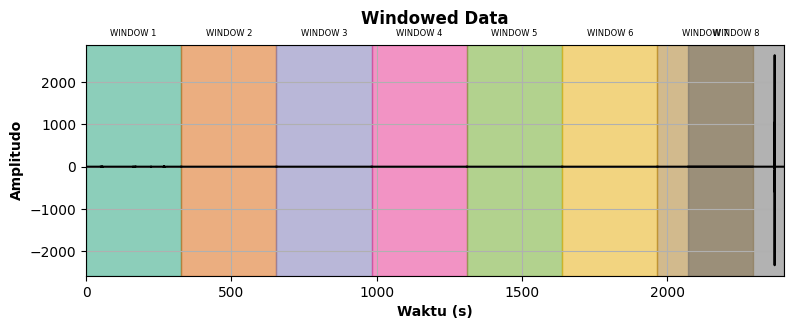

In [10]:
win= Windowing('r3', datas[2]['Time'][0], datas[2]['Amplitude'][0], 2**15, f'{path}/processing')
n, time, amplitude= win.windowing()
win.plot_windows()
win.save_to_txt()

In [15]:
path, path_data, path_processing= windows.get_paths()